# Giới thiệu đề tài

Một khoản vay có nên được phê duyệt hay không? Các ngân hàng có thể đánh giá rủi ro của một đơn xin vay mới được không?

Với một bộ dữ liệu khoản vay của Cơ quan quản lý doanh nghiệp nhỏ Hoa Kỳ (U.S. Small Business Administration - SBA) được cung cấp, hãy đưa ra lời khuyên cho ngân hàng để ra quyết định nêu trên.

# Làm rõ yêu cầu

* Mục đích: Bản chất của hoạt động cho vay là dựa trên sự tin tưởng về việc Khách hàng sẽ hoàn trả tiền vay. Trường hợp Khách hàng không trả được nợ sẽ dẫn đến thiệt hại về vốn cho ngân hàng. Một trong các mục đích của ngân hàng là hạn chế các thiệt hại này thông qua nhận diện các Khách hàng xấu để từ chối cho vay. Bên cạnh đó ngân hàng cũng muốn tối đa hoá dư nợ cho vay (quy mô cho vay) từ đó tăng thu nhập từ lãi vay. Điều đó cũng đòi hỏi ngân hàng không từ chối những Khách hàng có nhiều khả năng là Khách hàng tốt.

* Mục tiêu: Để đạt được mục đích đề ra ta cần phải dự đoán được liệu Khách hàng có trả được nợ hay không trong tương lai. Trường hợp kết quả dự đoán là "trả được nợ" thì ngân hàng có thể quyết định cho Khách hàng đó vay. Ngược lại nếu kết quả dự đoán là "không trả được nợ" thì để bảo toàn vốn ngân hàng có thể thông báo từ chối cho vay.

# Xác định cách tiếp cận giải quyết vấn đề

* Có thể thấy bài toán này là một bài toán phân loại với kết quả đầu ra dưới dạng nhị phân (trả được nợ/ không trả được nợ).

* Để xây dựng được mô hình dự đoán như yêu cầu, ta có thể sử dụng các phương pháp học có giám sát để huấn luyện mô hình trên dữ liệu đã có sẵn sau đó sử dụng mô hình để dự đoán cho các quan sát mới.

* Một trong lựa chọn có thể sử dụng là hồi quy Logistic. Trong nghiên cứu, đây sẽ là mô hình cơ sở để so sánh với các mô hình khác phức tạp hơn. Điểm mạnh của phương pháp này: Ít phức tạp, dễ giải thích, xác định được hướng, mức độ ảnh hưởng của thuộc tính đầu vào lên kết quả.

* Xây dựng mô hình nâng cao: Sử dụng các phương pháp Gradient Boosting, Random Forest, mạng neuron... để xây dựng mô hình khớp tốt hơn so với hồi quy Logistic. Qua việc đánh giá hiệu suất của các mô hình trên tập dữ liệu kiểm tra để chọn ra mô hình tối ưu.

# Xác định các yêu cầu đối với dữ liệu

Với các phương pháp đã lựa chọn, nguồn dữ liệu đầu vào cần đáp ứng các yêu cầu sau:

* Dữ liệu đầu vào là dữ liệu có cấu trúc (bảng gồm hàng và cột);
* Đối tượng cần đánh giá là từng khoản vay do đó mỗi một dòng trong bảng sẽ là một khoản vay đã được cho vay trong một giai đoạn nào đó;
* Mỗi một khoản vay cần được dán nhãn trả được nợ/ không trả được nợ;
* Để thực hiện các phương pháp nâng cao (Gradient Boosting, Random Forest, mạng neuron...) dữ liệu cần có số lượng quan sát đủ lớn để tránh tình trạng quá khớp và kết quả đầu ra thiếu tính khái quát.

# Thu thập dữ liệu

* Nguồn dữ liệu được tải về từ https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied
* Bảng dữ liệu chính nằm trên file SBAnational.csv, ta sẽ sử dụng thư viện Pandas để load dữ liệu vào đối tượng DataFrame để tiện cho việc phân tích ở các bước sau.
* Loại bỏ các dòng chưa được gắn nhãn

In [ ]:
# Linux command
!mkdir data
!wget -q -P data https://www.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342/suppl_file/ujse_a_1434342_sm1547.zip
!cd data && unzip ujse_a_1434342_sm1547.zip
!ls data/

In [1]:
import pandas as pd

raw_df = pd.read_csv('data/SBAnational.csv')
print(raw_df.shape[0], 'rows loaded')
raw_df = raw_df[~raw_df['MIS_Status'].isna()]
print('Drop NA')
print(raw_df.shape[0], 'rows remain')

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


899164 rows loaded
Drop NA
897167 rows remain


# Hiểu dữ liệu

In [79]:
import utils

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import *

# Define constant
POSITIVE = 'CHGOFF'
NEGATIVE = 'P I F'
LABELS = [NEGATIVE, POSITIVE]
API_KEY = '545ab510-8aa0-11ec-ad0d-8929d7c50b49'

## Thời điểm dữ liệu

* IQR1 = 60 (75% khoản vay có kỳ hạn trên 60 tháng)
* Dữ liệu được thu thập đến 2014, các khoản vay xấu chỉ có thể xác định đến thời điểm 2014. Do đa số các khoản vay có kỳ hạn dài như phân tích trên, rủi ro là dữ liệu đầu vào không bao gồm các khoản vay giải ngân trước 2014 nhưng đến trong tương lai và chưa xác định được là khoản vay tốt hay vay xấu
* Để tránh dữ liệu bị thiên lệch về các khoản vay xấu, ta loại bỏ các khoản vay có ngày giải ngân trong vòng 60 tháng đến thời điểm 2014

In [3]:
iqr1 = raw_df['Term'].quantile(0.25)
print('Term IQR1:', iqr1)

disburse = date_value(raw_df[['DisbursementDate']], max_year=2020)['DisbursementDate']
term = pd.DateOffset(months=iqr1)
chgoff = date_value(raw_df[['ChgOffDate']], max_year=2020)['ChgOffDate']
max_chgoff = chgoff.max()
print('Max charge off date:', max_chgoff)
max_disburse = max_chgoff - term
print('Disbursement date less than:', max_disburse)
raw_df = raw_df[disburse < max_disburse]
print(raw_df.shape[0], 'rows remain')

Term IQR1: 60.0
Max charge off date: 2014-08-29 00:00:00
Disbursement date less than: 2009-08-29 00:00:00
849674 rows remain


## Phân tách tập huấn luyện, kiểm tra

Tỷ lệ 85 / 15

In [4]:
y = raw_df['MIS_Status'].copy()
raw_df.drop(columns='MIS_Status', inplace=True)

x_train, x_test, y_train, y_test = train_test_split(raw_df,
                                                    y,
                                                    train_size=0.85,
                                                    random_state=11,
                                                    stratify=y)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

del raw_df

x_train shape: (722222, 26)
x_test shape: (127452, 26)
y_train shape: (722222,)
y_test shape: (127452,)


## Biến mục tiêu

* Biến mục tiêu có phân phối không đều. Để khắc phục, trong quá trình huấn luyện ta sẽ đưa vào trọng số (class weight).
* Biến mục tiêu đang được mã thành 2 loại:
    - P I F = 'Paid in full' (Trả được nợ)
    - CHGOFF = 'Charged off' (Không trả được nợ)
* Tại bước chuẩn bị dữ liệu các loại này sẽ được chuyển thành mã 0 và 1 tương ứng.

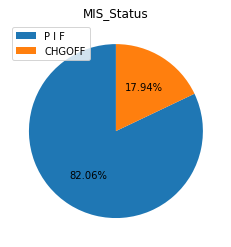

Positive class weights: 4.575669144837915


In [6]:
counts = y_train.value_counts()
plt.pie(counts,
        startangle=90,
        autopct='%.2f%%')

plt.title('MIS_Status')
plt.legend(counts.index)
plt.show()

## Biến giải thích

Cùng xem qua dữ liệu:

In [7]:
print('DataFrame head:')
display(x_train.head())
print()

print('Columns details:')
display(get_df_info(x_train))

DataFrame head:


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
812585,8709934007,STEWART PRESS,MORENO,CA,92557,OPUS BANK,CA,541430,17-Mar-05,2005,...,1,0,N,NaN,31-Mar-05,"$313,800.00",$0.00,$0.00,"$313,800.00","$235,350.00"
796045,8499173009,"COLLINS TECHNICAL RESEARCH, IN",SAN ANTONIO,TX,78217,TRUSTMARK NATIONAL BANK,TX,0,12-Jul-95,1995,...,0,N,N,NaN,31-Oct-95,"$135,000.00",$0.00,$0.00,"$135,000.00","$114,750.00"
822386,8825954010,DOMINO'S,POINT ROBERTS,WA,98281,"READYCAP LENDING, LLC",CA,722211,29-Apr-05,2005,...,2,0,N,NaN,30-Jun-05,"$349,000.00",$0.00,$0.00,"$349,000.00","$261,750.00"
836170,8968943008,"OBJECT SERVICES & CONSULTING,I",DALLAS,TX,75230,BANK OF AMERICA NATL ASSOC,NC,541511,29-Jan-96,1996,...,0,0,N,NaN,31-May-97,"$100,000.00",$0.00,$0.00,"$100,000.00","$50,000.00"
898249,9976283005,GREAT GROUNDS BY WOODY,SPRINGFIELD,IL,62707,"PNC BANK, NATIONAL ASSOCIATION",IL,561730,20-Feb-97,1997,...,0,N,Y,NaN,31-Mar-97,"$15,000.00",$0.00,$0.00,"$15,000.00","$12,000.00"



Columns details:


,Column,Count,Null count,Num unique,Type
0,LoanNr_ChkDgt,722222,0,722222,int64
1,Name,722213,9,636405,object
2,City,722195,27,28559,object
3,State,722210,12,51,object
4,Zip,722222,0,31971,int64
5,Bank,720921,1301,5374,object
6,BankState,720915,1307,55,object
7,NAICS,722222,0,1288,int64
8,ApprovalDate,722222,0,8356,object
9,ApprovalFY,722222,0,59,object


### DisbursementGross, GrAppv, SBA_Appv (số tiền giải ngân, số tiền phê duyệt, số tiền SBA bảo lãnh)

* Dữ liệu dưới dạng chuỗi (ví dụ: $10,000.00) cần được chuyển thành float.
* Các phân phối đều lệch phải. Thực hiện biến đổi log, qua biểu đồ trực quan hoá có thể thấy các khoản vay PIF có số tiền lớn hơn khoản vay CHGOFF.
* Nhìn biểu đồ phân tán có thể thấy 3 biến này có quan hệ tuyến tính rõ với nhau. Do đó ta chỉ chọn 1 trong 3 biến để đưa vào huấn luyện.

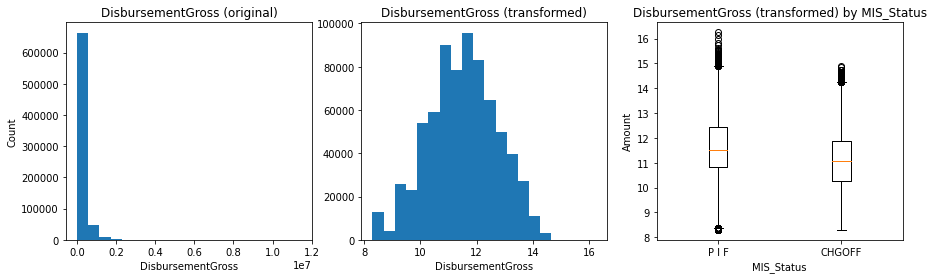

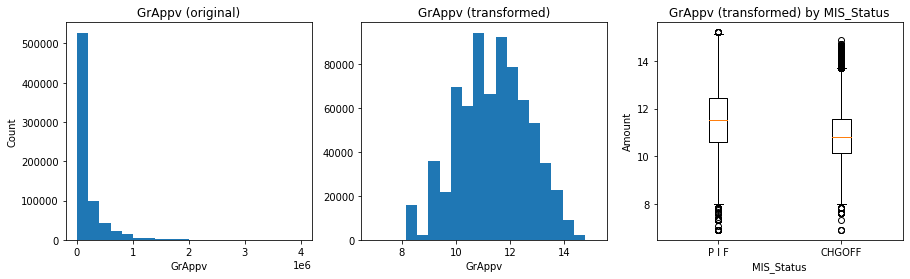

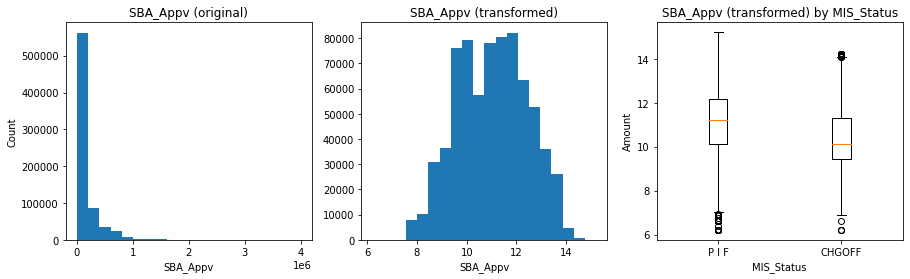

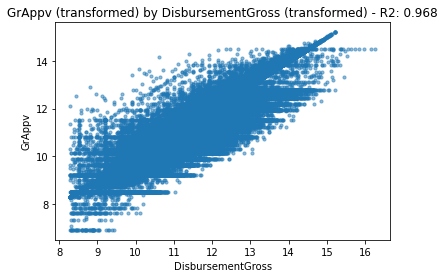

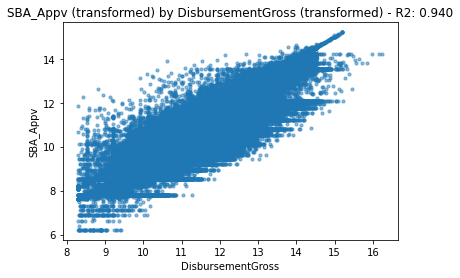

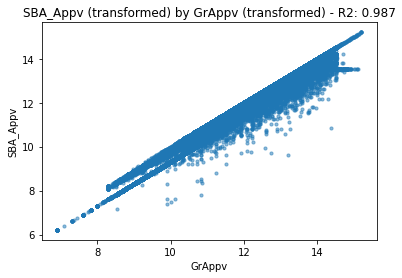

In [8]:
cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv']

amounts = amount_value(x_train[cols])
transformed_amounts = pd.DataFrame(np.log(amounts),
                                   index=amounts.index,
                                   columns=cols)

for col in cols:
    plot_hist_and_boxplot(amounts[col],
                          transformed_amounts[col],
                          y_train,
                          LABELS)
plt.show()

pairs = [('DisbursementGross', 'GrAppv'),
         ('DisbursementGross', 'SBA_Appv'),
         ('GrAppv', 'SBA_Appv')]

corr_mat = transformed_amounts.corr()

for f1, f2 in pairs:
    plt.scatter(transformed_amounts[f1],
                transformed_amounts[f2],
                s=10.0,
                alpha=0.5)
    plt.title(f'{f2} (transformed) by {f1} (transformed) - R2: {corr_mat.loc[f1, f2]:.3f}')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

### SBA_Appv_portion (tỷ lệ bảo lãnh của SBA)

Khi loại bỏ GrAppv và SBA_Appv và thay thế bằng tỷ lệ SBA_Appv / GrAppv thì biến mới này có khả năng giải thích kết quả CHGOFF / PIF. Lý lẽ là khi SBA đánh giá khoản vay có khả năng trả được nợ thì mới chấp nhận tỷ lệ bảo lãnh cao và ngược lại.

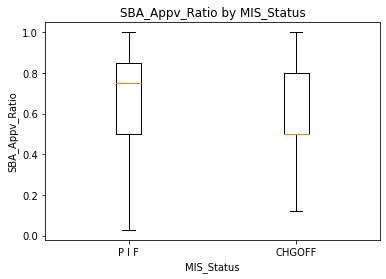

In [9]:
sba_ratio = amounts['SBA_Appv'] / amounts['GrAppv']
sba_ratio.name = 'SBA_Appv_Ratio'
plot_box(sba_ratio, y_train, LABELS)
plt.show()

### BalanceGross, ChgOffPrinGr (Dư nợ, Dư nợ không trả được)

* Với mục tiêu xác định có trả được nợ hay không chỉ cần căn cứ vào MIS_Status và có thể bỏ qua ChgOffPrinGr.
* Phần lớn BalanceGross bằng 0 do KH đã trả hết nợ hoặc chuyển thành nợ không trả được do đó cũng có thể bỏ qua.

In [10]:
print('BalanceGross counts:')
x_train['BalanceGross'].value_counts()

BalanceGross counts:


$0.00           722211
$25,000.00           1
$600.00              1
$96,908.00           1
$996,262.00          1
$827,875.00          1
$41,509.00           1
$37,100.00           1
$12,750.00           1
$395,476.00          1
$115,820.00          1
$9,111.00            1
Name: BalanceGross, dtype: int64

### DisbursementDate (ngày giải ngân)

Ngày giải ngân đến 2009 như phân tích trên. Định dạng dưới dạng chuỗi (ví dụ 3-Jun-89) cần được chuyển đổi thành datetime

In [6]:
disburse_dates = date_value(x_train[['DisbursementDate']], max_year=2020)
disburse_dates = disburse_dates['DisbursementDate']
print('Converted DisbursementDate:')
disburse_dates.dropna().sort_values()

Converted DisbursementDate:


54648    1948-09-17
49244    1966-08-16
732056   1968-11-22
726149   1969-05-22
720402   1969-05-26
            ...    
370854   2009-08-27
371406   2009-08-27
370925   2009-08-27
364770   2009-08-28
369332   2009-08-28
Name: DisbursementDate, Length: 722222, dtype: datetime64[ns]

### Term (kỳ hạn)

* Kỳ hạn vay không bị thiếu dữ liệu. Tuy nhiên có khoảng 700 trường hợp có kỳ hạn bằng 0 có thể gán giá trị mode.
* Các khoản vay CHGOFF thường có kỳ hạn thấp hơn khoản vay PIF.

Zero Term counts:


False    721526
True        696
Name: Term, dtype: int64

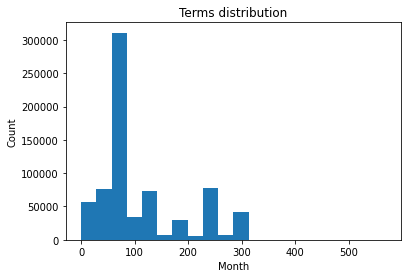

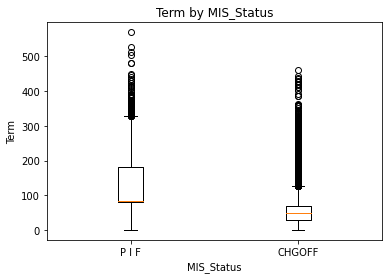

In [7]:
terms = x_train['Term']
print('Zero Term counts:')
cond = (terms==0)
display(cond.value_counts())

plt.hist(terms, bins=20)
plt.title('Terms distribution')
plt.ylabel('Count')
plt.xlabel('Month')
plt.show()

plot_box(x_train['Term'], y_train, LABELS)
plt.show()

### Recession (suy thoái kinh tế)

* Các khoản vay có trải qua giai đoạn suy thoái kinh tế (tháng 12/2007 đến tháng 6/2009) có tỷ lệ CHGOFF cao hơn các giai đoạn khác (giá trị p của thử nghiệm Chi bình phương cho kết quả nhỏ hơn 0.005). Đây là biến được tạo ra để đưa vào huấn luyện (https://en.wikipedia.org/wiki/Great_Recession)
* Điều kiện xác định khoản vay trải qua giai đoạn suy thoái kinh tế:
    + Ngày hết hạn trước 30/06/2009
    + Ngày giải ngân sau 01/12/2007
    + Trong đó Ngày hết hạn = ngày bắt đầu + kỳ hạn

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


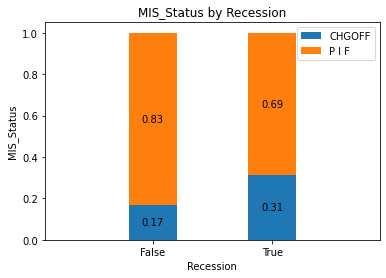

Chi square: 7422.820608517174 p-value: 0.0


In [8]:
recession = mature_between(disburse_dates,
                           x_train['Term'],
                           '2007-12-01',
                           '2009-06-30')
recession.name = 'Recession'

counts = x_train.pivot_table(index=y_train,
                             columns=recession,
                             values='LoanNr_ChkDgt',
                             aggfunc='count')

portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.show()

chi2_test(pd.DataFrame(recession), y_train)

### City, State, Zip (thành phố, bang, zip code)

* Số bang = 51 (50 bang + Washington DC), số thành phố, Zip code có hơn 30.000 quan sát.
* Với 12 trường hợp thiếu dữ liệu có thể suy luận từ mã Zip. Ở đây sử dụng REST API từ [app.zipcodebase.com](app.zipcodebase.com). Các trường hợp còn lại sử dụng 2 ký tự cuối của City.
* Các biến này đều thể hiện địa điểm của Khách hàng. Để giảm số lượng nhóm ta sẽ chọn bang (State) để đưa vào huấn luyện.
* Luận điểm ở đây: Mỗi bang ở nước Mỹ có 1 hệ thống pháp luật, môi trường kinh doanh, cơ cấu kinh tế khác nhau do đó có thể có tỷ lệ CHGOFF khác nhau. Ta có thể kiểm chứng qua việc vẽ biểu đồ trực quan hoá.

Missing State:


,City,Zip,State
351072,"1542,TABUK,SAUDI ARABIA",79925,NaN
306274,"BOX 267, APO AP",96205,NaN
366158,CASCO,54205,NaN
885335,A452638533,76645,NaN
49244,JOHNSTOWN NY,0,NaN
871847,A452638533,76052,NaN
366139,PALM BEACH GARDENS,33410,NaN
328526,WICHITA,67219,NaN
385418,LAKE OZARK,65049,NaN
869948,A452638533,75236,NaN


Find State from Zip:
API request: https://app.zipcodebase.com/api/v1/search?codes=79925%2C96205%2C54205%2C76645%2C0%2C76052%2C33410%2C67219%2C65049%2C75236%2C84124%2C95682&country=US
Result: {79925: 'TX', 96205: '', 54205: 'WI', 76645: 'TX', 76052: 'TX', 33410: 'FL', 67219: 'KS', 65049: 'MO', 75236: 'TX', 84124: 'UT', 95682: 'CA'}


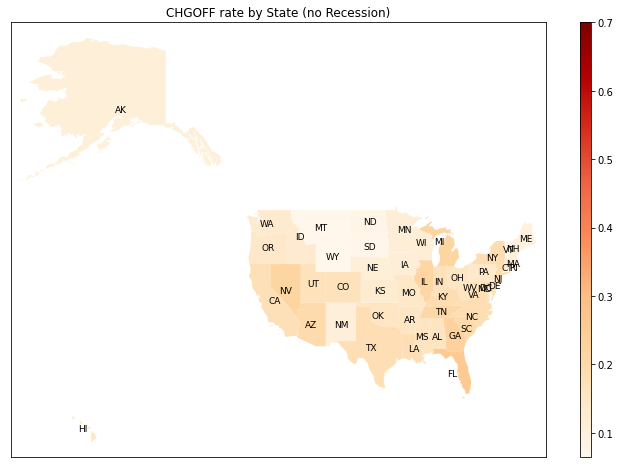

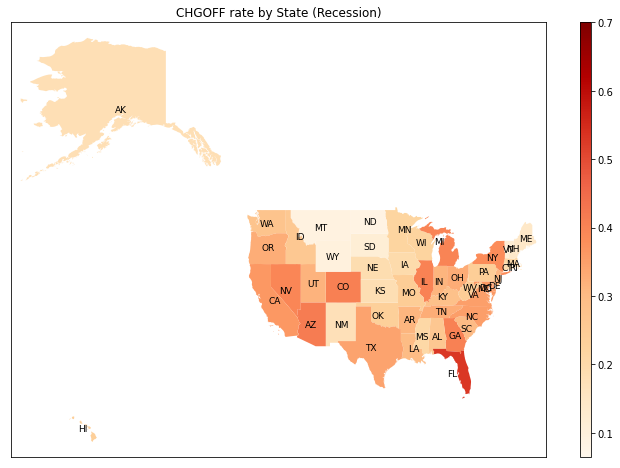

In [9]:
cond = x_train['State'].isna()
print('Missing State:')
display(x_train.loc[cond, ['City', 'Zip', 'State']])

zips = x_train.loc[cond, 'Zip']
print('Find State from Zip:')
zip_mapping = zip_to_state(zips, API_KEY)
print('Result:', zip_mapping)

x = pd.DataFrame({'State': state_imputer(x_train, zip_mapping),
                  'Recession': recession})

def plot_states_data(feature, x, y, vmin=None, vmax=None):
    recession = x['Recession']
    state_rate = target_rate_by_feature(x.loc[~recession, feature],
                                        y_train[~recession])
    state_rate = state_rate[POSITIVE]
    state_recession_rate = target_rate_by_feature(x.loc[recession, feature],
                                                  y_train[recession])
    state_recession_rate = state_recession_rate[POSITIVE]

    # Note same scale
    vmin = vmin or min(state_rate.min(), state_recession_rate.min())
    vmax = vmax or max(state_rate.max(), state_recession_rate.max())

    plot_geospartial(state_rate,
                     (12, 8),
                     cmap='OrRd',
                     title=f'{POSITIVE} rate by {feature} (no Recession)',
                     vmin=vmin,
                     vmax=vmax)

    plot_geospartial(state_recession_rate,
                     (12, 8),
                     cmap='OrRd',
                     title=f'{POSITIVE} rate by {feature} (Recession)',
                     vmin=vmin,
                     vmax=vmax)

    plt.show()

plot_states_data('State', x, y_train, vmax=0.7)

### Bank, BankState (ngân hàng, bang của ngân hàng)

Tỷ lệ CHGOFF giữa các BankState cũng có sự khác biệt

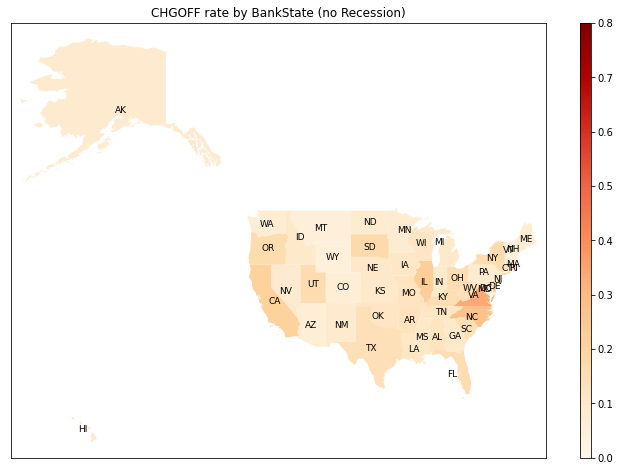

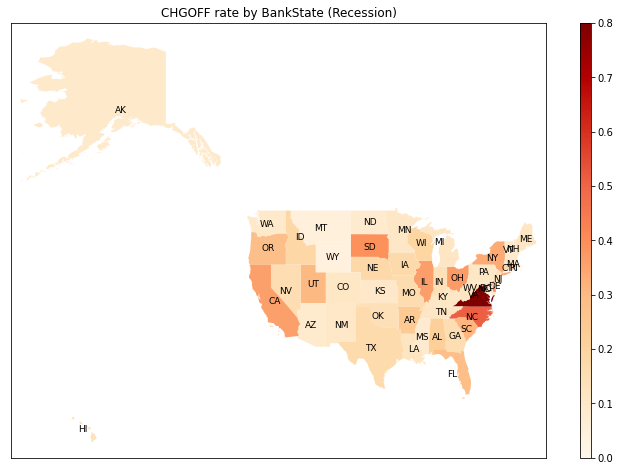

In [15]:
x = pd.DataFrame({'BankState': x_train['BankState'],
                  'Recession': recession})

plot_states_data('BankState', x, y, vmax=0.8)

### NAICS (mã ngành)

* Có khoảng 170.000 trường hợp thiếu dữ liệu mã ngành (=0).
* 2 ký tự đầu cột này được code từ 11 - 92 cho mỗi ngành, tổng cộng 24 loại theo bảng tham số naics.csv.
* Thực hiện nhóm các ngành thành nhóm ngành (ví dụ 31, 32, 33 cùng nhóm Manufacturing).
* Các nhóm ngành khác nhau có mức độ rủi ro khác nhau có tỷ lệ CHGOFF sẽ khác nhau.
* Trong thời kỳ suy thoái, sự thay đổi tỷ lệ CHGOFF là khác nhau giữa các ngành (ví dụ Public Administration có tỷ lệ CGHOFF tăng mạnh)

In [5]:
# Get NAICS mapping
naics_map_df = pd.read_csv('data/naics.csv', index_col=0)
NAICS_CODES = naics_map_df['IndustryCode']
print('NAICS mapping:')
display(naics_map_df.head(10))

INDUSTRY_DESC = naics_map_df.groupby('IndustryCode').agg('first').iloc[:, 0]

NAICS mapping:


,IndustryCode,Description
NAICS,,
0,0,Missing
11,1,"Agriculture, forestry, fishing and hunting"
21,2,"Mining, quarrying, and oil and gas extraction"
22,3,Utilities
23,4,Construction
31,5,Manufacturing
32,5,Manufacturing
33,5,Manufacturing
42,6,Wholesale trade


NAICS mapping:


,IndustryCode,Description
NAICS,,
0,0,Missing
11,1,"Agriculture, forestry, fishing and hunting"
21,2,"Mining, quarrying, and oil and gas extraction"
22,3,Utilities
23,4,Construction
31,5,Manufacturing
32,5,Manufacturing
33,5,Manufacturing
42,6,Wholesale trade


Missing industry counts:


False    551119
True     171103
Name: Industry, dtype: int64

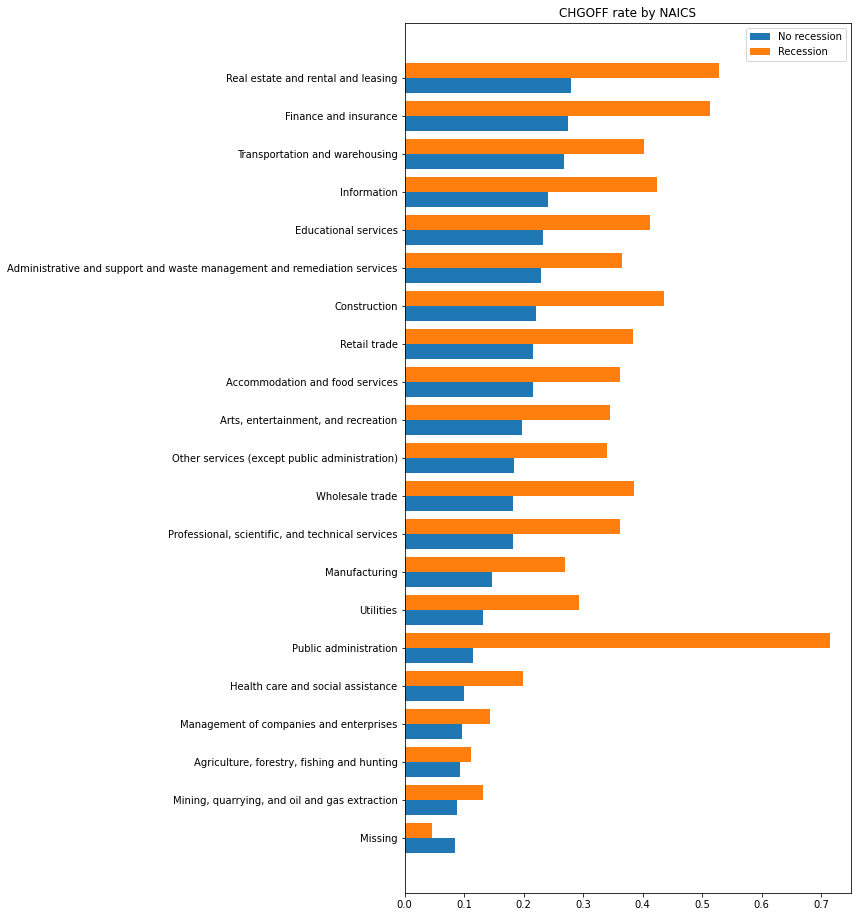

In [10]:
# Plot industries
x = x_train['NAICS'].map(lambda x: int(str(x)[:2])).map(NAICS_CODES)
x.name = 'Industry'

print('Missing industry counts:')
cond = (x==0)
display(cond.value_counts())

industry = target_rate_by_feature(x[~recession],
                                  y_train[~recession])
industry = industry[POSITIVE]

industry_recession = target_rate_by_feature(x[recession],
                                            y_train[recession])
industry_recession = industry_recession[POSITIVE]

industry_df = pd.concat([industry,
                         industry_recession],
                        axis='columns')
industry_df.index = industry_df.index.astype(np.int64).map(INDUSTRY_DESC)
industry_df.columns = ['No recession', 'Recession']
industry_df = industry_df.sort_values('No recession')
y = np.arange(industry_df.shape[0])
plt.figure(figsize=(8, 16))
plt.barh(y - 0.2, industry_df['No recession'], height=0.4)
plt.barh(y + 0.2, industry_df['Recession'], height=0.4)
plt.yticks(y, industry_df.index)
plt.title(f'{POSITIVE} rate by NAICS')
plt.legend(industry_df.columns)
plt.show()

### NewExist (Khách hàng là doanh nghiệp mới)

* Định nghĩa Khách hàng mới:
    * Khách hàng thành lập trên 2 năm: Giá trị 1
    * Khách hàng thành lập từ 2 năm trở xuống: Giá trị 2
    * Thiếu dữ liệu: Giá trị 0
* Qua quan sát biểu đồ thì biến này không có ảnh hưởng nhiều tới kết quả.
* Có gần 900 trường hợp thiếu dữ liệu có thể gán bằng 1 (giá trị mode)

NewExist counts:


1.0    518359
2.0    202997
0.0       866
Name: NewExist, dtype: int64

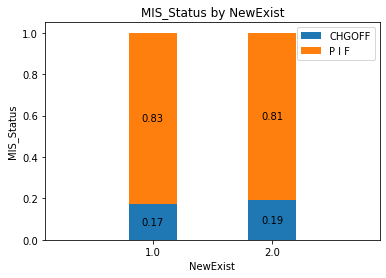

In [17]:
print('NewExist counts:')
display(x_train['NewExist'].value_counts(dropna=False))

new_exist = x_train['NewExist'].fillna(0)
cond = (new_exist != 0)
counts = pd.DataFrame(y_train[cond]).pivot_table(index=y_train[cond],
                                                 columns=new_exist[cond],
                                                 values=y_train.name,
                                                 aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.show()

### NoEmp (Số lao động)

* Có 3767 trường hợp số lao động bằng không có thể thay thế bằng giá trị median
* Phân phối lệch phải. Thực hiện biến đổi log, qua biểu đồ trực quan hoá có thể thấy các khoản vay PIF thì Khách hàng có nhiều lao động hơn khoản vay CHGOFF (Quy mô lớn hơn thì có khả năng trả nợ tốt hơn).

Zero employment counts:


False    718455
True       3767
Name: NoEmp, dtype: int64

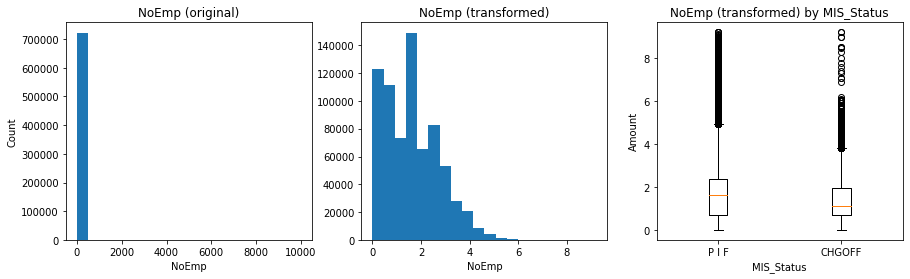

In [18]:
emp = x_train['NoEmp'].copy()
print('Zero employment counts:')
cond = (emp==0)
display(cond.value_counts())

emp[cond] = emp.median()

plot_hist_and_boxplot(emp,
                      np.log(emp),
                      y_train,
                      LABELS)

### FranchiseCode (Nhượng quyền)

* Các giá trị:
    * 0, 1: Không nhượng quyền
    * Các giá trị khác: Có nhượng quyền
* Qua quan sát biểu đồ thì biến này không có ảnh hưởng nhiều tới kết quả.

FranchiseCode counts:


1        540174
0        139906
78760      2681
68020      1639
50564       868
          ...  
69800         1
4258          1
80988         1
64855         1
10562         1
Name: FranchiseCode, Length: 2510, dtype: int64

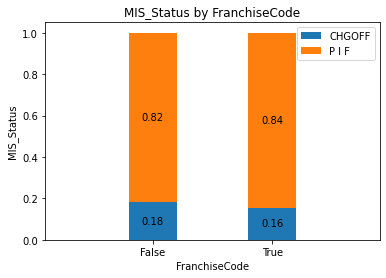

In [19]:
franchise = x_train['FranchiseCode']
print('FranchiseCode counts:')
display(franchise.value_counts())

franchise = (franchise > 1)
counts = pd.DataFrame(y_train).pivot_table(index=y_train,
                                           columns=franchise,
                                           values=y_train.name,
                                           aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.show()

### UrbanRural (Đô thị, nông thôn)

* Các giá trị:
    * 1: Đô thị
    * 2: Nông thôn
    * 0: Không xác định
* Số lượng quan sát không xác định (0) là lớn (khoảng 270.000) do đó ta loại trừ biến này trong quá trình huấn luyện

UrbanRural counts:


1    367582
0    274111
2     80529
Name: UrbanRural, dtype: int64

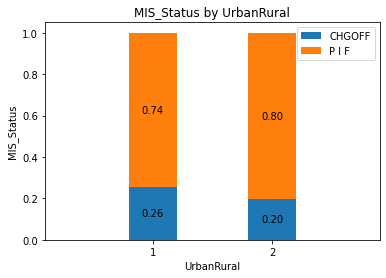

In [20]:
urban_rural = x_train['UrbanRural']
print('UrbanRural counts:')
display(urban_rural.value_counts())
cond = (urban_rural>0)

counts = pd.DataFrame(y_train[cond]).pivot_table(index=y_train[cond],
                                                 columns=urban_rural[cond],
                                                 values=y_train.name,
                                                 aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.show()

### RevLineCr (Vay tuần hoàn)

* Các giá trị:
    * Y: Có
    * N: Không
    * Khác: Lỗi, thiếu dữ liệu
* Số lượng quan sát lỗi, thiếu dữ liệu là lớn (khoảng 230.000) do đó ta loại trừ biến này trong quá trình huấn luyện

RevLineCr counts:


N      332027
0      218555
Y      155560
T       12559
NaN      3466
1          20
`          11
R          10
2           4
5           1
.           1
7           1
,           1
C           1
A           1
4           1
3           1
Q           1
-           1
Name: RevLineCr, dtype: int64

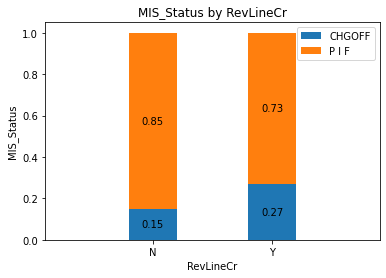

In [21]:
rev_line_cr = x_train['RevLineCr']
print('RevLineCr counts:')
display(rev_line_cr.value_counts(dropna=False))
cond = rev_line_cr.isin(['Y', 'N'])

counts = pd.DataFrame(y_train[cond]).pivot_table(index=y_train[cond],
                                                 columns=rev_line_cr[cond],
                                                 values=y_train.name,
                                                 aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.show()

### LowDoc (Vay ít hồ sơ)

* Các giá trị:
    * Y: Có
    * N: Không
    * Khác: Lỗi, thiếu dữ liệu
* Các trường hợp lỗi, thiếu dữ liệu có thể gán bằng giá trị mode.
* Các trường hợp vay LowDoc có tỷ lệ CHGOFF thấp hơn vay thông thường (giá trị p của thử nghiệm Chi bình phương nhỏ hơn 0.005).

LowDoc counts:


N      624913
Y       93643
0        1270
NaN      1028
C         654
A         382
S         289
R          42
1           1
Name: LowDoc, dtype: int64

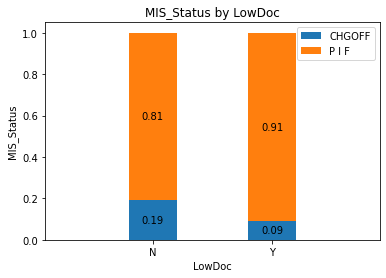

Chi square: 5069.6133985096685 p-value: 0.0


In [22]:
low_doc = x_train['LowDoc']
print('LowDoc counts:')
display(low_doc.value_counts(dropna=False))
cond = low_doc.isin(['Y', 'N'])

counts = pd.DataFrame(y_train[cond]).pivot_table(index=y_train[cond],
                                                 columns=low_doc[cond],
                                                 values=y_train.name,
                                                 aggfunc='count')
portions = counts / counts.sum()
plot_stacked_bars(portions)
plt.show()

low_doc = low_doc[cond].copy()
low_doc = low_doc.replace({'Y': 1, 'N':0})
chi2_test(pd.DataFrame(low_doc),
          y_train[cond])

# Chuẩn bị dữ liệu

## Xây dựng pipeline

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def amount_transformer_func(x):
    x = amount_value(x)
    x['DisbursementGross'] = np.log(x['DisbursementGross'])
    x['SBA_Appv_portion'] = x['SBA_Appv'] / x ['GrAppv']
    return x[['DisbursementGross', 'SBA_Appv_portion']]

def date_transformer_func(x):
    x = x.copy()
    x[['DisbursementDate']] = date_value(x[['DisbursementDate']], max_year=2020)
    cond = (x['Term']==0)
    x.loc[cond, 'Term'] = x['Term'].mode()[0]
    x['Recession'] = mature_between(x['DisbursementDate'],
                                    x['Term'],
                                    '2007-12-01',
                                    '2009-06-30')
    x['Recession'] = x['Recession'].astype('int')
    return x[['Term', 'Recession']]

def state_transformer_func(x):
    states = x['State'] 
    cond = states.isna()
    zips = x.loc[cond, 'Zip']
    if len(zips) > 0:
        zip_mapping = zip_to_state(zips, API_KEY)
        states = state_imputer(x, zip_mapping)
    bankstates = x['BankState'].copy()
    cond = bankstates.isna()
    bankstates[cond] = bankstates.mode()[0]
    df = pd.DataFrame({'State': states,
                       'BankState': bankstates})
    return df

def industry_transformer_func(x):
    industry = x['NAICS'].map(lambda x: int(str(x)[:2])).map(NAICS_CODES)
    df = pd.DataFrame({'Industry': industry})
    return df

def noemp_transformer_func(x):
    x = x.copy()
    cond = (x['NoEmp']==0)
    x.loc[cond, 'NoEmp'] = x['NoEmp'].median()
    x['NoEmp'] = np.log(x['NoEmp'])
    return x[['NoEmp']]

def lowdoc_transformer_func(x):
    x = x.copy()
    cond = x['LowDoc'].isna()
    x.loc[cond, 'LowDoc'] = x['LowDoc'].mode()[0]
    x['LowDoc'] = (x['LowDoc'] == 'Y').astype(np.int64)
    return x[['LowDoc']]

stage1 = ColumnTransformer([
    ('amount_transformer', FunctionTransformer(amount_transformer_func), ['DisbursementGross', 'SBA_Appv', 'GrAppv']),
    ('date_transformer', FunctionTransformer(date_transformer_func), ['DisbursementDate', 'ApprovalDate', 'Term']),
    ('state_transformer', FunctionTransformer(state_transformer_func), ['State', 'City', 'Zip', 'BankState']),
    ('industry_transformer', FunctionTransformer(industry_transformer_func), ['NAICS']),
    ('noemp_transformer', FunctionTransformer(noemp_transformer_func), ['NoEmp']),
    ('lowdoc_transformer', FunctionTransformer(lowdoc_transformer_func), ['LowDoc']),
])

stage2 = ColumnTransformer([
        ('scaler', MinMaxScaler(), [0, 2, 7]),
        ('encode_state', OneHotEncoder(sparse=False), [4, 5]),
        ('encode_industry', OneHotEncoder(sparse=False), [6]),
    ],
    remainder='passthrough'
)

stage3 = FunctionTransformer(lambda x: x.astype(np.float32))

x_pipeline = Pipeline([
    ('stage1', stage1),
    ('stage2', stage2),
    ('stage3', stage3)
])

## Xử lý dữ liêu

In [7]:
x_train_processed = x_pipeline.fit_transform(x_train)
y_pipeline = FunctionTransformer(lambda x: (x==POSITIVE).astype('int'))
y_train_processed = y_pipeline.fit_transform(y_train)
x_test_processed = x_pipeline.transform(x_test)
y_test_processed = y_pipeline.transform(y_test)

print('x train shape:', x_train_processed.shape)
print('x test shape:', x_test_processed.shape)
print('y train shape:', y_train_processed.shape)
print('y test shape:', y_test_processed.shape)

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


API request: https://app.zipcodebase.com/api/v1/search?codes=79925%2C96205%2C54205%2C76645%2C0%2C76052%2C33410%2C67219%2C65049%2C75236%2C84124%2C95682&country=US


/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


API request: https://app.zipcodebase.com/api/v1/search?codes=54025&country=US
x train shape: (722222, 134)
x test shape: (127452, 134)
y train shape: (722222,)
y test shape: (127452,)


# Xây dựng mô hình

## Mô hình Logistic

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, auc, make_scorer, precision_recall_curve
import pickle

In [36]:
# Load pretrain model
with open('lr_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)

In [8]:
def pr_auc_scorer(y, yprob):
    precision, recall, _ = precision_recall_curve(y, yprob)
    return auc(recall, precision)

lr_model = LogisticRegressionCV(max_iter=300,
                                Cs=5,
                                scoring=make_scorer(pr_auc_scorer, needs_proba=True),
                                solver='sag')

In [9]:
lr_model.fit(x_train_processed, y_train_processed)

/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sonhn/learning/datascience/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

LogisticRegressionCV(Cs=5, max_iter=300,
                     scoring=make_scorer(pr_auc_scorer, needs_proba=True),
                     solver='sag')

In [37]:
idx = np.where(lr_model.Cs_ == lr_model.C_[0])[0][0]
print('PR AUC validation Score:', lr_model.scores_[1][:, idx].mean())

PR AUC validation Score: 0.5924374950839375


In [35]:
# Save model
with open('lr_model.pkl','wb') as f:
    pickle.dump(lr_model, f)

## Mô hình MLP

In [55]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import callbacks

mlp_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(x_train_processed.shape[1],), name='d1'),
    layers.Dense(256, activation='relu', name='d2'),
    layers.Dense(64, activation='relu', name='d3'),
    layers.Dense(32, activation='relu', name='d4'),
    layers.Dense(1, activation='sigmoid', name='d5')
])

mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d1 (Dense)                  (None, 128)               17280     
                                                                 
 d2 (Dense)                  (None, 256)               33024     
                                                                 
 d3 (Dense)                  (None, 64)                16448     
                                                                 
 d4 (Dense)                  (None, 32)                2080      
                                                                 
 d5 (Dense)                  (None, 1)                 33        
                                                                 
Total params: 68,865
Trainable params: 68,865
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Load pretrain weights
mlp_model.load_weights('mpl_model_best_weigh.h5')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d1 (Dense)                  (None, 128)               17280     
                                                                 
 d2 (Dense)                  (None, 256)               33024     
                                                                 
 d3 (Dense)                  (None, 64)                16448     
                                                                 
 d4 (Dense)                  (None, 32)                2080      
                                                                 
 d5 (Dense)                  (None, 1)                 33        
                                                                 
Total params: 68,865
Trainable params: 68,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1129/1129 [============================

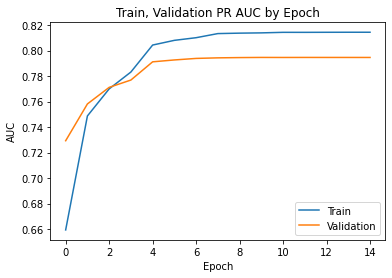

In [42]:
mlp_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics.AUC(curve='PR', name='auc'))

cbs = [
    callbacks.ModelCheckpoint('mlp_model_best_weigh.h5',
                              monitor='val_auc',
                              save_best_only=True,
                              save_weights_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_auc',
                                factor=0.1,
                                patience=3,
                                min_delta=0.002)
]

hist = mlp_model.fit(x_train_processed,
                     y_train_processed,
                     batch_size=512,
                     epochs=15,
                     validation_split=0.2,
                     callbacks=cbs)

hist_df = pd.DataFrame.from_dict(hist.history)
plt.plot(hist_df['auc'], label='Train')
plt.plot(hist_df['val_auc'], label='Validation')
plt.title('Train, Validation PR AUC by Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

## Mô hình Gradient Boosting

In [43]:
import xgboost as xgb

x_train_xgb, x_eval_xgb, y_train_xgb, y_eval_xgb = train_test_split(
    x_train_processed,
    y_train_processed,
    train_size=0.8,
    random_state=11,
    stratify=y_train_processed)

dtrain = xgb.DMatrix(x_train_xgb, label=y_train_xgb)
deval = xgb.DMatrix(x_eval_xgb, label=y_eval_xgb)

In [47]:
params = {
    'booster': 'gbtree',
    'max_depth': 6,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr'
}   

In [51]:
bst = xgb.train(params,
                dtrain,
                num_boost_round=40,
                evals=[(deval, 'eval'), (dtrain, 'train')])

[0]	eval-aucpr:0.76811	train-aucpr:0.77102
[1]	eval-aucpr:0.79059	train-aucpr:0.79400
[2]	eval-aucpr:0.81578	train-aucpr:0.81917
[3]	eval-aucpr:0.82551	train-aucpr:0.82968
[4]	eval-aucpr:0.83217	train-aucpr:0.83586
[5]	eval-aucpr:0.84043	train-aucpr:0.84321
[6]	eval-aucpr:0.84186	train-aucpr:0.84482
[7]	eval-aucpr:0.84526	train-aucpr:0.84835
[8]	eval-aucpr:0.84942	train-aucpr:0.85236
[9]	eval-aucpr:0.85468	train-aucpr:0.85732
[10]	eval-aucpr:0.85634	train-aucpr:0.85899
[11]	eval-aucpr:0.85904	train-aucpr:0.86142
[12]	eval-aucpr:0.86057	train-aucpr:0.86331
[13]	eval-aucpr:0.86396	train-aucpr:0.86663
[14]	eval-aucpr:0.86504	train-aucpr:0.86760
[15]	eval-aucpr:0.86740	train-aucpr:0.86954
[16]	eval-aucpr:0.86823	train-aucpr:0.87039
[17]	eval-aucpr:0.86880	train-aucpr:0.87103
[18]	eval-aucpr:0.87037	train-aucpr:0.87306
[19]	eval-aucpr:0.87073	train-aucpr:0.87354
[20]	eval-aucpr:0.87239	train-aucpr:0.87507
[21]	eval-aucpr:0.87319	train-aucpr:0.87555
[22]	eval-aucpr:0.87478	train-aucpr:0.8774

## So sánh kết quả mô hình

* Căn cứ F1 score, đường cong Precision-Recall có thể thấy mô hình Gradient Boosting cho kết quả tốt nhất giữa 3 mô hình.
* Tỷ lệ recall (phát hiện khoản vay xấu) của mô hình Gradient Boosting là 0.78 (tại ngưỡng xác suất 0,5). Tỷ lệ này có có thể được cải thiện bằng cách thay đổi ngưỡng xác suất. Khi đó ta chấp nhận precision giảm (dương tính giả tăng). Đây là sự đánh đổi có thể chấp nhận vì cho vay khoản vay xấu sẽ làm ngân hàng tốn nhiều chi phí hơn là từ chối một khách hàng tốt. Cụ thể với ngưỡng 0.3358 có thì recall 0.85, precision 0.795, f1 score 0.8216

In [94]:
print('F1 score:')

print('='*60)
print('Logistic model:')
print('='*60)
yprob_lr = lr_model.predict_proba(x_test_processed)
yhat = lr_model.predict(x_test_processed)
print(classification_report(y_test_processed, yhat))

print('='*60)
print('MLP model:')
print('='*60)
yprob_mlp = mlp_model.predict(x_test_processed)
yhat = (yprob[:, 0]>0.5).astype('int')
print(classification_report(y_test_processed, yhat))

print('='*60)
print('Gradient Boosting model:')
print('='*60)
yprob_bst = bst.predict(xgb.DMatrix(x_test_processed))
yhat = (yprob_bst>0.5).astype('int')
print(classification_report(y_test_processed, yhat))

F1 score:
Logistic model:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    104593
           1       0.72      0.32      0.44     22859

    accuracy                           0.86    127452
   macro avg       0.79      0.65      0.68    127452
weighted avg       0.84      0.86      0.83    127452

MLP model:
              precision    recall  f1-score   support

           0       0.28      0.03      0.05    104593
           1       0.13      0.68      0.22     22859

    accuracy                           0.14    127452
   macro avg       0.21      0.35      0.14    127452
weighted avg       0.25      0.14      0.08    127452

Gradient Boosting model:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    104593
           1       0.86      0.78      0.82     22859

    accuracy                           0.94    127452
   macro avg       0.90      0.88      0.89    127452
weighted avg

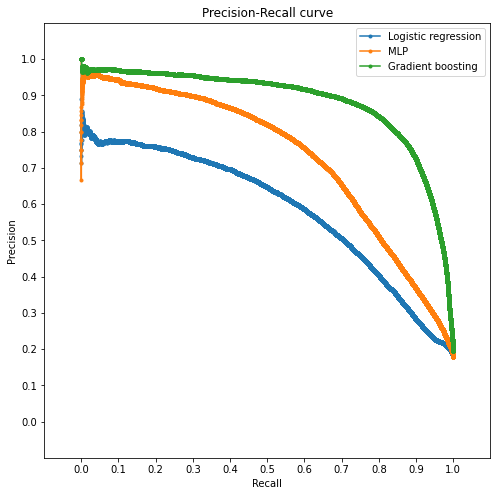

In [97]:
plt.figure(figsize=(8, 8))
precision, recall, _ = precision_recall_curve(y_test_processed, yprob_lr[:, 1])
plot_auc(precision, recall, y_test_processed, 'Logistic regression')

precision, recall, _ = precision_recall_curve(y_test_processed, yprob_mlp[:, 0])
plot_auc(precision, recall, y_test_processed, 'MLP')

precision, recall, threshold = precision_recall_curve(y_test_processed, yprob_bst)
plot_auc(precision, recall, y_test_processed, 'Gradient boosting')

plt.title(f'Precision-Recall curve')
plt.legend()
plt.show()

In [107]:
cond = (recall>0.84999) & (recall<0.85009)
pd.DataFrame({'threshold': threshold[cond[:-1]],
              'recall': recall[cond],
              'precision': precision[cond]})

,threshold,recall,precision
0,0.335703,0.850081,0.794992
1,0.335766,0.850081,0.795025
2,0.335776,0.850037,0.795017
3,0.335822,0.850037,0.795049
4,0.335826,0.849993,0.795041
5,0.335880,0.849993,0.795073
6,0.335907,0.849993,0.795106
7,0.336058,0.849993,0.795138
8,0.336063,0.849993,0.795171
